In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumGothic')
sns.set(font="Malgun Gothic")

In [2]:
def detect_outliers(df,columns):
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    iqr=q3-q1
    
    boundary=1.5*iqr
    
    index1=df[df[columns] > q3+boundary].index
    index2=df[df[columns] < q1-boundary].index 
    
#     df.loc[:,columns]=df[columns].drop(index1)
#     df.loc[:,columns]=df[columns].drop(index2)

    df = df.drop(index1)
    df = df.drop(index2)
    
    return df

def detect_outliers_per_group(df, group_column, value_column):
    group_values = set(df[group_column])
    df_list = []
    for group_value in group_values:
        sub_df = df[df[group_column] == group_value]
        
        sub_df = detect_outliers(sub_df, value_column)
#         sub_df[value_column] = sub_df[value_column]
        sub_df = sub_df.dropna()
        df_list.append(sub_df)
    return pd.concat(df_list)

# 프로그램 파라미터

In [3]:
ORIGIN_DATA_DIR = "data/origin"
RESULT_DATA_DIR = "data/extracted"

AGENT_LOG_FILE_NAME = "play_enemy_log.csv"
PLAYER_LOG_FILE_NAME = "play_log.csv"
RESULT_FILE_NAME = "log.csv"

# 데이터 추출

In [4]:
# 필요한 데이터 추출
def extract_log():
    
    dir_list = os.listdir(ORIGIN_DATA_DIR)
    df_list = [] 
    for i, dir_name in enumerate(dir_list):
        # player log data load 및 전처리
        player_log_path = os.path.join(ORIGIN_DATA_DIR, dir_name, PLAYER_LOG_FILE_NAME)
        player_df = pd.read_csv(player_log_path, encoding = "cp949")
        del player_df["kill"]

        # agent log data load 및 전처리
        agent_log_path = os.path.join(ORIGIN_DATA_DIR, dir_name, AGENT_LOG_FILE_NAME)  
        agent_df = pd.read_csv(agent_log_path, encoding = "cp949")
        agent_df = agent_df[["episode", "dead"]]
        agent_df["kill"] = agent_df["dead"]
        del agent_df["dead"]
        

        df = pd.merge(player_df, agent_df, on = "episode")
        df["id"] = i
        
        df_list.append(df)
        
    # 모두 합치기
    df = pd.concat(df_list)
    
    # 전처리
    df["death"] = df["dead"]
    del df["dead"]
    
    df["win"] = df["death"] < df["kill"]
    df.replace("aimer", "Artisan", inplace = True)
    df.replace("runner", "Explorer", inplace = True)
    df.replace("aggressive", "Manager", inplace = True)
    df.replace("defensive", "Conqueror", inplace = True)
    df.replace("hider", "Guardian", inplace = True)
    
    # save
    if not os.path.exists(RESULT_DATA_DIR):
        os.makedirs(RESULT_DATA_DIR)
        
    path = os.path.join(RESULT_DATA_DIR, RESULT_FILE_NAME)
    df.to_csv(path, index=False, encoding = "cp949")

extract_log()

# 전체 데이터

In [5]:
def get_df():
    path = os.path.join(RESULT_DATA_DIR, RESULT_FILE_NAME)
    return pd.read_csv(path, encoding = "cp949")
get_df()

,id,name,episode,agent,start_time,end_time,kill,death,win
0,0,wjkang,0,Conqueror,2022-11-16 17:42:06.522048,2022-11-16 17:44:03.917702,1.0,2.0,False
1,0,wjkang,1,Manager,2022-11-16 17:44:37.618432,2022-11-16 17:46:35.027854,1.0,4.0,False
2,0,wjkang,2,Artisan,2022-11-16 17:46:58.489084,2022-11-16 17:48:56.036679,2.0,1.0,True
3,0,wjkang,3,Guardian,2022-11-16 17:49:12.668111,2022-11-16 17:51:10.127473,2.0,2.0,False
4,0,wjkang,4,Explorer,2022-11-16 17:51:29.024036,2022-11-16 17:53:26.591287,9.0,0.0,True
...,...,...,...,...,...,...,...,...,...
115,11,choijundoo,5,Conqueror,2022-11-17 00:36:41.034138,2022-11-17 00:38:38.260896,2.0,9.0,False
116,11,choijundoo,6,Manager,2022-11-17 00:38:58.073796,2022-11-17 00:40:55.325331,4.0,5.0,False
117,11,choijundoo,7,Artisan,2022-11-17 00:41:13.922727,2022-11-17 00:43:11.382712,4.0,3.0,True
118,11,choijundoo,8,Guardian,2022-11-17 00:43:30.962506,2022-11-17 00:45:28.105594,6.0,2.0,True


# Agent 분석

In [6]:
# 모든 Agent
def get_all_agent_df():
    df = get_df()
    df = df.groupby("agent").count()
    return df[[]]

get_all_agent_df()

""
agent
Artisan
Conqueror
Explorer
Guardian
Manager


In [7]:
# agent별 대전 횟수
def get_agent_battle_count_df(df):
    df = df[["agent"]]
    df.insert(0,'battle_count', 1)
    df = df.groupby("agent").count()
    
    all_agent_df = get_all_agent_df()
    df = pd.merge(all_agent_df, df, on = "agent", how="outer")
    return df.fillna(0)

df = get_df()
get_agent_battle_count_df(df)

,battle_count
agent,
Artisan,24
Conqueror,24
Explorer,24
Guardian,24
Manager,24


In [8]:
# agent별 승리 횟수
def get_agent_win_count_df(df):
    df = df[["agent", "win"]]
    df = df[df["win"] == False]
    df.loc[:, "win"] = 1
    df = df.groupby("agent").count()
    
    all_agent_df = get_all_agent_df()
    df = pd.merge(all_agent_df, df, on = "agent", how="outer")
    return df.fillna(0)

df = get_df()
get_agent_win_count_df(df)

,win
agent,
Artisan,15
Conqueror,23
Explorer,1
Guardian,14
Manager,21


In [9]:
# agent별 승률
def agent_winning_rate_df(df):
    agent_battle_df = get_agent_battle_count_df(df)
    agent_win_df = get_agent_win_count_df(df)
    df = pd.merge(agent_battle_df, agent_win_df, on="agent")
    df["winning_rate"] = df["win"]/df["battle_count"]
    return df[["winning_rate"]]

df = get_df()
agent_winning_rate_df(df)

,winning_rate
agent,
Artisan,0.625000
Conqueror,0.958333
Explorer,0.041667
Guardian,0.583333
Manager,0.875000


# Player 분석

In [10]:
# 모든 Player
def get_all_player_df():
    df = get_df()
    df = df.groupby("id").count()
    return df[[]]

get_all_player_df()

""
id
0
1
2
3
4
5
6
7
8


In [11]:
# agent별 대전 횟수
def get_player_battle_count_df(df):
    df = df[["id"]]
    df.insert(0,'battle_count', 1)
    return df.groupby("id").count()

df = get_df()
get_player_battle_count_df(df)

,battle_count
id,
0,10
1,10
2,10
3,10
4,10
5,10
6,10
7,10
8,10


In [12]:
# player별 승리 횟수
def get_player_win_count_df(df):
    df = df[["id", "win"]]
    df = df[df["win"] == True]
    df["win"] = 1
    return df.groupby("id").count()

df = get_df()
get_player_win_count_df(df)

,win
id,
0,4
1,3
2,4
3,3
4,4
5,2
6,2
7,1
8,8


In [13]:
# player별 승률
def get_player_winning_rate_df(player_battle, player_win):
    df = pd.merge(player_battle, player_win, on="id")
    df["winning_rate"] = df["win"]/df["battle_count"]
    return df[["winning_rate"]]

df = get_df()
player_battle = get_player_battle_count_df(df)
player_win = get_player_win_count_df(df)
get_player_winning_rate_df(player_battle, player_win)

,winning_rate
id,
0,0.4
1,0.3
2,0.4
3,0.3
4,0.4
5,0.2
6,0.2
7,0.1
8,0.8


In [14]:
# 상위권 플레이어
def get_top_player_df(df, ratio, reverse = False):
    player_battle = get_player_battle_count_df(df)
    player_win = get_player_win_count_df(df)
    df = get_player_winning_rate_df(player_battle, player_win)
    df = df.sort_values(by="winning_rate", ascending = reverse)
    df = df.head(int(len(df)*0.3))
    return df[[]]

df = get_df()
get_top_player_df(df, 0.3)

""
id
8
10
11


# 상위권 플레이어에 대한 Agent 승률

In [15]:
# 상위권 플레이어 데이터
def get_top_player_date(df, ratio, reverse = False):
    top_player_df = get_top_player_df(df, ratio, reverse = reverse)
    return pd.merge(df, top_player_df, on="id", how="inner")

df = get_df()
get_top_player_date(df, 0.3, reverse = False)

,id,name,episode,agent,start_time,end_time,kill,death,win
0,8,junryeoljeon,0,Conqueror,2022-11-16 17:09:42.487693,2022-11-16 17:11:40.051407,4.0,2.0,True
1,8,junryeoljeon,1,Manager,2022-11-16 17:11:50.852956,2022-11-16 17:13:48.359317,3.0,1.0,True
2,8,junryeoljeon,2,Artisan,2022-11-16 17:13:54.638878,2022-11-16 17:15:52.184785,3.0,2.0,True
3,8,junryeoljeon,3,Guardian,2022-11-16 17:15:56.953925,2022-11-16 17:17:54.159993,4.0,2.0,True
4,8,junryeoljeon,4,Explorer,2022-11-16 17:18:02.729591,2022-11-16 17:20:00.309240,11.0,1.0,True
5,8,junryeoljeon,5,Conqueror,2022-11-16 17:20:13.353394,2022-11-16 17:22:10.552081,1.0,2.0,False
6,8,junryeoljeon,6,Manager,2022-11-16 17:22:17.376577,2022-11-16 17:24:14.625584,3.0,2.0,True
7,8,junryeoljeon,7,Artisan,2022-11-16 17:24:19.671374,2022-11-16 17:26:17.220405,3.0,3.0,False
8,8,junryeoljeon,8,Guardian,2022-11-16 17:26:22.225452,2022-11-16 17:28:19.776063,7.0,2.0,True
9,8,junryeoljeon,9,Explorer,2022-11-16 17:28:30.556479,2022-11-16 17:30:28.025156,13.0,0.0,True


In [16]:
# 상위권 플레이어에 대한 Agent별 승률
df = get_df()
df = get_top_player_date(df, 0.3, False)
agent_winning_rate_df(df)

,winning_rate
agent,
Artisan,0.333333
Conqueror,0.833333
Explorer,0.000000
Guardian,0.166667
Manager,0.500000


# 최종 승률 테이블

In [17]:
df_list = []
df = get_df()
df = get_top_player_date(df, 0.3, False)
df = agent_winning_rate_df(df)
df["Top(30%)"] = df["winning_rate"]
del df["winning_rate"]
df_list.append(df)

df = get_df()
df = get_top_player_date(df, 0.7, True)
df = agent_winning_rate_df(df)
df["Bottop(70%)"] = df["winning_rate"]
del df["winning_rate"]
df_list.append(df)

df = get_df()
df = agent_winning_rate_df(df)
# df["total"] = df["winning_rate"]
df["Total"] = df["winning_rate"]
del df["winning_rate"]
df_list.append(df)

df = pd.concat(df_list, axis = 1)
for column in df.columns:
    df[column] = round(df[column], 2)

df.sort_values("Total", ascending = False)

,Top(30%),Bottop(70%),Total
agent,,,
Conqueror,0.83,1.00,0.96
Manager,0.50,1.00,0.88
Artisan,0.33,1.00,0.62
Guardian,0.17,1.00,0.58
Explorer,0.00,0.17,0.04


# agent별 kill

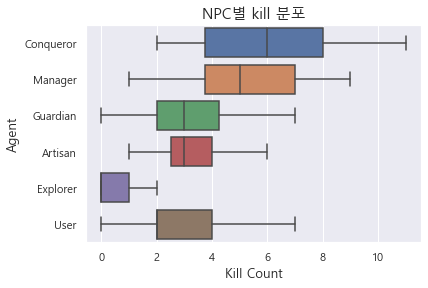

In [18]:
# agent-kill
df = get_df()
df["kill"] = df["death"] # 플레이어 기준 -> agent 기준
df = df[["agent", "kill"]]

# user-kill
df2 = get_df()
df2.loc[:,"agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "kill"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "kill")

sns.boxplot(data=df, y = "agent", x="kill", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("NPC별 kill 분포", fontsize=15)
plt.xlabel("Kill Count", fontsize = 13)
plt.ylabel("Agent", fontsize = 13)

plt.show()

# agent별 death

Text(0, 0.5, 'Agent')

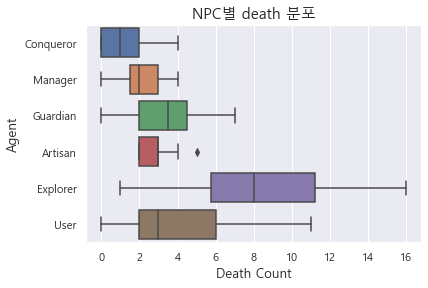

In [19]:
# agent-death
df = get_df()
df["death"] = df["kill"] # 플레이어 기준 -> agent 기준

# user-death
df2 = get_df()
df2["agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "death"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "death")

p = sns.boxplot(data=df, y = "agent", x="death", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("NPC별 death 분포", fontsize=15)
plt.xlabel("Death Count", fontsize = 13)
plt.ylabel("Agent", fontsize = 13)

# agent별 K/D rate

Text(0.5, 0, 'Kill/Death Rate')

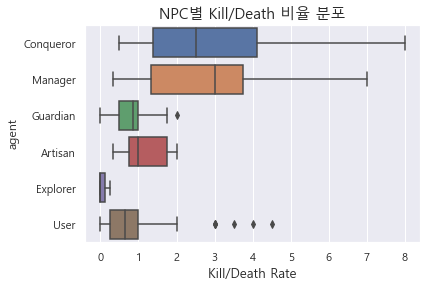

In [20]:
# agent-K/D
df = get_df()
df["K-D-rate"] = df["death"]/df["kill"]
df = df[["agent", "K-D-rate"]]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# user-death
df2 = get_df()
df2["agent"] = "User"
df2["K-D-rate"] = df2["kill"]/df2["death"]

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "K-D-rate"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "K-D-rate")

sns.boxplot(data=df, y = "agent", x="K-D-rate", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("NPC별 Kill/Death 비율 분포", fontsize=15)
plt.xlabel("Kill/Death Rate", fontsize = 13)

# agent의 death가 0인 데이터 수

In [21]:
df = get_df()
df = df[["agent", "kill"]]
df = df[df["kill"] == 0]
print(len(df))
df

12


,agent,kill
5,Conqueror,0.0
10,Conqueror,0.0
38,Guardian,0.0
45,Conqueror,0.0
50,Conqueror,0.0
53,Guardian,0.0
55,Conqueror,0.0
56,Manager,0.0
70,Conqueror,0.0
78,Guardian,0.0


# Agent 별 kill, death, K/D 분포

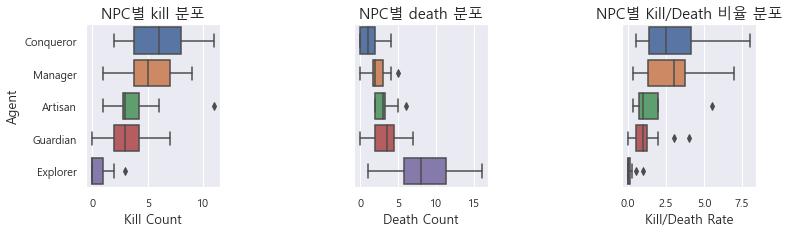

In [22]:
# plt.rc('font', family='NanumGothic')
sns.set(font="Malgun Gothic")

plt.figure(figsize=(12, 3))
plt.subplots_adjust(wspace = 1)

plt.subplot(131)
df = get_df()
df["kill"] = df["death"] # 플레이어 기준 -> agent 기준
sns.boxplot(data=df, y = "agent", x="kill", orient = "h")
plt.title("NPC별 kill 분포", fontsize=15)
plt.ylabel("Agent", fontsize = 13)
plt.xlabel("Kill Count", fontsize = 13)

# p.set_title("NPC 별 kill 분포")


plt.subplot(132)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기
df = get_df()
df["death"] = df["kill"] # 플레이어 기준 -> agent 기준
sns.boxplot(data=df, y = "agent", x="death", orient = "h")
plt.title("NPC별 death 분포", fontsize=15)
plt.xlabel("Death Count", fontsize = 13)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기


plt.subplot(133)
# plt.axis("off")
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기
df = get_df()
df["K-D-rate"] = df["death"]/df["kill"]
df = df[["agent", "K-D-rate"]]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
sns.boxplot(data=df, y = "agent", x="K-D-rate", orient = "h")
plt.title("NPC별 Kill/Death 비율 분포", fontsize=15)
plt.xlabel("Kill/Death Rate", fontsize = 13)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기


plt.show()

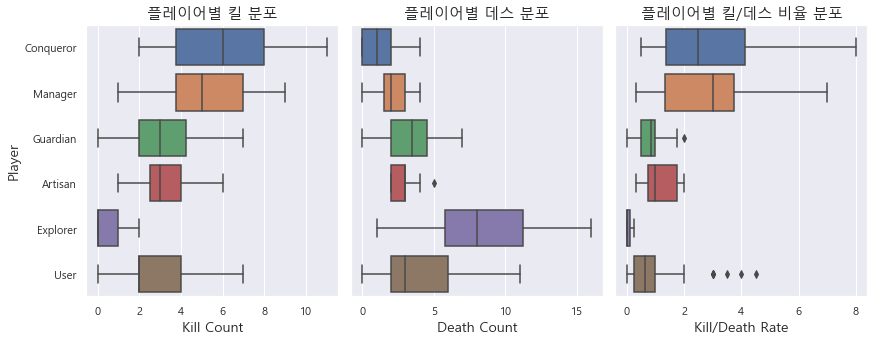

In [23]:
sns.set(font="Malgun Gothic")

plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace = 0.05)

########################################################################
plt.subplot(131)
# agent-kill
df = get_df()
df["kill"] = df["death"] # 플레이어 기준 -> agent 기준
df = df[["agent", "kill"]]

# user-kill
df2 = get_df()
df2.loc[:,"agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "kill"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "kill")

sns.boxplot(data=df, y = "agent", x="kill", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 킬 분포", fontsize=15)
plt.xlabel("Kill Count", fontsize = 14)
plt.ylabel("Player", fontsize = 14)

########################################################################
plt.subplot(132)
# agent-death
df = get_df()
df["death"] = df["kill"] # 플레이어 기준 -> agent 기준

# user-death
df2 = get_df()
df2["agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "death"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "death")

p = sns.boxplot(data=df, y = "agent", x="death", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 데스 분포", fontsize=15)
plt.xlabel("Death Count", fontsize = 14)
plt.ylabel("Player", fontsize = 14)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기

########################################################################
plt.subplot(133)
# agent-K/D
df = get_df()
df["K-D-rate"] = df["death"]/df["kill"]
df = df[["agent", "K-D-rate"]]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# user-death
df2 = get_df()
df2["agent"] = "User"
df2["K-D-rate"] = df2["kill"]/df2["death"]

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "K-D-rate"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "K-D-rate")

sns.boxplot(data=df, y = "agent", x="K-D-rate", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 킬/데스 비율 분포", fontsize=15)
plt.xlabel("Kill/Death Rate", fontsize = 14)
plt.ylabel("Player", fontsize = 14)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기

# plt.tight_layout()
plt.savefig("NPC별 킬 데스 분포.png")

In [24]:
df = get_df()
df[df["kill"] == 0].groupby("agent").count()

,id,name,episode,start_time,end_time,kill,death,win
agent,,,,,,,,
Conqueror,8,8,8,8,8,8,8,8
Guardian,3,3,3,3,3,3,3,3
Manager,1,1,1,1,1,1,1,1


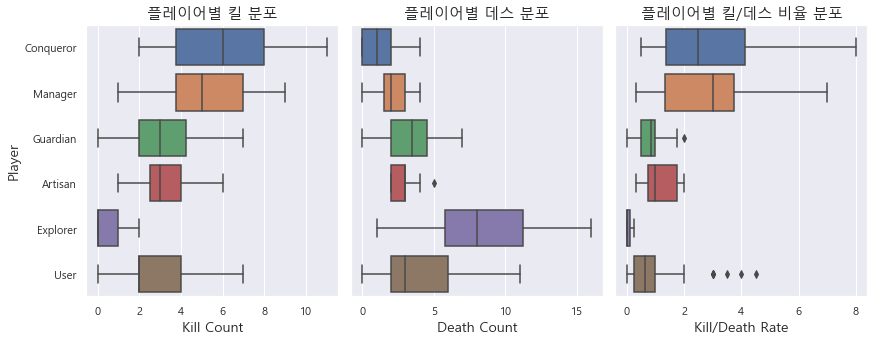

In [25]:
sns.set(font="Malgun Gothic")

plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace = 0.05)

########################################################################
plt.subplot(131)
# agent-kill
df = get_df()
df["kill"] = df["death"] # 플레이어 기준 -> agent 기준
df = df[["agent", "kill"]]

# user-kill
df2 = get_df()
df2.loc[:,"agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "kill"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "kill")

sns.boxplot(data=df, y = "agent", x="kill", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 킬 분포", fontsize=15)
plt.xlabel("Kill Count", fontsize = 14)
plt.ylabel("Player", fontsize = 14)

########################################################################
plt.subplot(132)
# agent-death
df = get_df()
df["death"] = df["kill"] # 플레이어 기준 -> agent 기준

# user-death
df2 = get_df()
df2["agent"] = "User"

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "death"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "death")

p = sns.boxplot(data=df, y = "agent", x="death", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 데스 분포", fontsize=15)
plt.xlabel("Death Count", fontsize = 14)
plt.ylabel("Player", fontsize = 14)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기

########################################################################
plt.subplot(133)
# agent-K/D
df = get_df()
df["K-D-rate"] = df["death"]/df["kill"]
df = df[["agent", "K-D-rate"]]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# user-death
df2 = get_df()
df2["agent"] = "User"
df2["K-D-rate"] = df2["kill"]/df2["death"]

# 합치기
df = pd.concat([df, df2])
df = df[["agent", "K-D-rate"]]

# 이상치 제거
df = detect_outliers_per_group(df, "agent", "K-D-rate")

sns.boxplot(data=df, y = "agent", x="K-D-rate", orient = "h", order=["Conqueror", "Manager", "Guardian", "Artisan", "Explorer", "User"])
plt.title("플레이어별 킬/데스 비율 분포", fontsize=15)
plt.xlabel("Kill/Death Rate", fontsize = 14)
plt.ylabel("Player", fontsize = 14)
plt.gca().axes.yaxis.set_visible(False) #y축만 없애기

# plt.tight_layout()
plt.savefig("NPC별 킬 데스 분포.svg")